# BindsNET Neuron (Node) Models

## 1. Table of Contents
1. Table of Contents
2. Overview
3. Import Statements
4. Network Structure
5. Neuron Models
    1. IFNodes
    2. LIFNodes
    3. CurrentLIFNodes
    4. AdaptiveLIFNodes
    5. SRM0Nodes

## 2. Overview
Detailed documentation of the node creation process has been specified [here](https://bindsnet-docs.readthedocs.io/guide/guide_part_i.html#creating-a-network). This document will go into more specific examples of configuring a spiking neural network in BindsNET.

## 3. Import Statements

In [130]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from bindsnet.encoding import *
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, IFNodes, SRM0Nodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor

from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_input, plot_weights

## 4. Network Structure

`Network` object is responsible for the coordination of simulation of all its constituent components: neurons, synapses, learning rules, etc.

The `dt` argument specifies the simulation time step in milliseconds

In [131]:
network = Network()



`Nodes` object describes the neural model for each layer of the network. The command below creates a single layer with two LIF neurons.
* one of either `n` or `shape` usually required
* `thresh` argument specifies threshold voltage for the layer
* `rest` argument specifies resting voltage for the layer
* `traces` keeps track of "spike traces"
* `tc_decay` argument specifies leakage

Classes of `Nodes`:
* Inputs
* McCullochPitts
* IFNodes
* LIFNodes
* CurrentLIFNodes
* AdaptiveLIFNodes
* DiehlAndCookNodes
* IzhikevichNodes
* SRM0Nodes

In [132]:
network = Network()

lif_layer = LIFNodes(n=2)

`Nodes` (layer) objects get added to the `Network` object

In [133]:
network = Network()

lif_layer = LIFNodes(n=2)

network.add_layer(
    layer=lif_layer, name="LIF population"
)

`AbstractConnection` objects connect the layers
* `source` and `target` layers must be specified
* `w` argument specifies the weight of the synapse
* `b` argument specifies the bias of the synapse
* `wmin` and `wmax` arguments specify the min and max allowable weight values
* `norm` argument is a floating point value used to normalize the weights

Recurrent connections can be formed by connecting a layer to itself

Classes of `AbstractConnection`:
* Connection
* Conv2dConnection
* MaxPool2dConnection
* LocalConnection
* MeanFieldConnection
* SparseConnection

In [134]:
# Create two populations of neurons, one to act as the "source"
# population, and the other, the "target population".
input_layer = Input(n=4)
lif_layer = LIFNodes(n=2)

# Connect the two layers.
connection = Connection(
    source=input_layer, target=lif_layer
)

# add the two layers to the network
network.add_layer(
    layer=input_layer, name="Input Layer"
)
network.add_layer(
    layer=lif_layer, name="LIF Layer"
)

# weights specified in connection
network.add_connection(
    connection=connection, source="Input Layer", target="LIF Layer"
)

`Montior` objects can record tensor valued variables (state variables from `Nodes` and `AbstractConnections` objects) over time

In [135]:
network = Network()

input_layer = Input(n=4)
lif_layer = LIFNodes(n=2)

# simulation duration in milliseconds
time = 100

connection = Connection(
    source=input_layer, target=lif_layer
)

# Create a monitor.
lif_layer_monitor = Monitor(
    obj=lif_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

# add layers to network
network.add_layer(
    layer=input_layer, name="Input Layer"
)
network.add_layer(
    layer=lif_layer, name="LIF Layer"
)

# add connection to network
network.add_connection(
    connection=connection, source="Input Layer", target="LIF Layer"
)

# add monitor to the network
network.add_monitor(monitor=lif_layer_monitor, name="LIF Layer")

`NetworkMonitor` can be used to record from several monitors at once

In [136]:
'''
network_monitor = NetworkMonitor(
    network: Network,
    layers: Optional[Iterable[str]],
    connections: Optional[Iterable[Tuple[str, str]]],
    state_vars: Optional[Iterable[str]],
    time: Optional[int],
)
'''

'\nnetwork_monitor = NetworkMonitor(\n    network: Network,\n    layers: Optional[Iterable[str]],\n    connections: Optional[Iterable[Tuple[str, str]]],\n    state_vars: Optional[Iterable[str]],\n    time: Optional[int],\n)\n'

`Network.run` used to simulate the network on provided input data

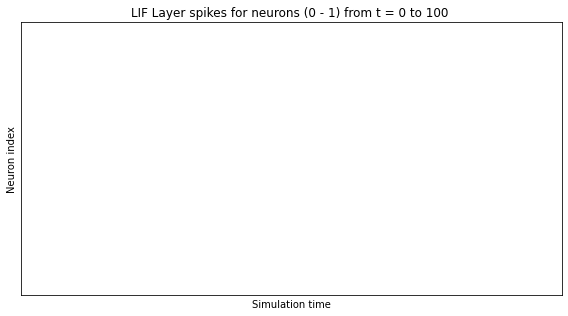

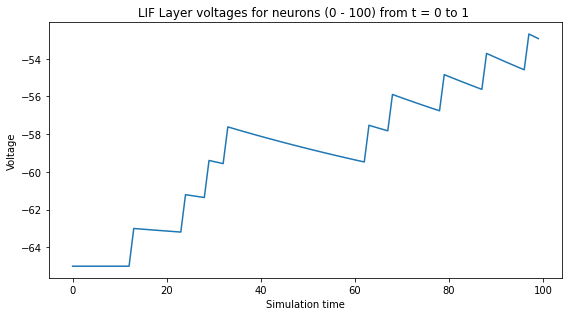

In [137]:
# initialize network
network = Network()

# set number of neurons
input_neurons = 1
lif_neurons = 1

# simulation time
time = 100
dt = 1

# configure weights for the synapses between the input layer and LIF layer
w = torch.round(torch.abs(2 * torch.randn(input_neurons, lif_neurons)))

# initialize input and LIF layers
input_layer = Input(n=input_neurons)
lif_layer = LIFNodes(n=lif_neurons)

# connection between the input layer and the LIF layer
connection = Connection(
    source=input_layer, target=lif_layer,w=w
)

# create a monitor
lif_layer_monitor = Monitor(
    obj=lif_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

# add layers to network
network.add_layer(
    layer=input_layer, name="Input Layer"
)
network.add_layer(
    layer=lif_layer, name="LIF Layer"
)

# add connection to network
network.add_connection(
    connection=connection, source="Input Layer", target="LIF Layer"
)

# add monitor to the network
network.add_monitor(monitor=lif_layer_monitor, name="LIF Layer")

# create input spike data, where each spike is distributed according to Bernoulli(0.1)
input_data = torch.bernoulli(0.1 * torch.ones(time, input_layer.n)).byte()
encoded_image = input_data
inputs = {"Input Layer": input_data}

# simulate network on input data
network.run(inputs=inputs, time=time)

# retrieve and plot simulation spike, voltage data from monitors
spikes = {"LIF Layer": lif_layer_monitor.get("s")}
voltages = {"LIF Layer": lif_layer_monitor.get("v")}

# plot spikes and voltages of the LIF layer
# TODO: plot axes
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
# plot_weights(w)

# plot image
# TODO: use a standard input image and encode it
# e_img = encoded_image.view(int(time / dt), 1, 1, input_layer.n, 1)
# inpt = e_img.view(int(time / dt), input_layer.n).sum(0).view(input_layer.n, 1)
# plot_input(input_data,inpt)

plt.show()

## 5. Neuron Models

### 5a. Integrate-and-Fire (IF) Model
Incoming spikes are integrated (added) to the membrane potential
### Parameters
Below is a table that describes the parameters that can be tweaked to customize the LIF Neuron model.

| Parameter       | Type                       | Description                                   | Default Value |
|-----------------|----------------------------|-----------------------------------------------|---------------|
| n               | Optional\[int]              | The number of neurons in the layer.           | None          |
| shape           | Optional\[Iterable\[int]]    | The dimensionality of the layer.              | None          |
| traces          | bool                       | Whether to record spike traces.               | False         |
| traces_additive | bool                       | Whether to record spike traces additively.    | False         |
| tc_trace        | Union\[float, torch.Tensor] | Time constant of spike trace decay.           | 20.0          |
| trace_scale     | Union\[float, torch.Tensor] | Scaling factor for spike trace.               | 1.0           |
| sum_input       | bool                       | Whether to sum all inputs.                    | False         |
| thresh          | Union\[float, torch.Tensor] | Spike threshold voltage.                      | -52.0         |
| rest            | Union\[float, torch.Tensor] | Resting membrane voltage.                     | -65.0         |
| reset           | Union\[float, torch.Tensor] | Post-spike reset voltage.                     | -65.0         |
| refrac          | Union\[int, torch.Tensor]   | Refractory (non-firing) period of the neuron. | 5             |
| tc_decay        | Union\[float, torch.Tensor] | Time constant of neuron voltage decay.        | 100.0         |
| lbound          | float                      | Lower bound of the voltage.                   | None          |


### 5b. Leaky Integrate-and-Fire (LIF) Model
Incoming spikes are integrated (added) to the membrane potential. The membrane potential decrements at each timestep.
### Parameters
Below is a table that describes the parameters that can be tweaked to customize the LIF Neuron model.

| Parameter       | Type                       | Description                                   | Default Value |
|-----------------|----------------------------|-----------------------------------------------|---------------|
| n               | Optional\[int]              | The number of neurons in the layer.           | None          |
| shape           | Optional\[Iterable\[int]]    | The dimensionality of the layer.              | None          |
| traces          | bool                       | Whether to record spike traces.               | False         |
| traces_additive | bool                       | Whether to record spike traces additively.    | False         |
| tc_trace        | Union\[float, torch.Tensor] | Time constant of spike trace decay.           | 20.0          |
| trace_scale     | Union\[float, torch.Tensor] | Scaling factor for spike trace.               | 1.0           |
| sum_input       | bool                       | Whether to sum all inputs.                    | False         |
| thresh          | Union\[float, torch.Tensor] | Spike threshold voltage.                      | -52.0         |
| rest            | Union\[float, torch.Tensor] | Resting membrane voltage.                     | -65.0         |
| reset           | Union\[float, torch.Tensor] | Post-spike reset voltage.                     | -65.0         |
| refrac          | Union\[int, torch.Tensor]   | Refractory (non-firing) period of the neuron. | 5             |
| tc_decay        | Union\[float, torch.Tensor] | Time constant of neuron voltage decay.        | 100.0         |
| lbound          | float                      | Lower bound of the voltage.                   | None          |

<!--
Tables generated using https://www.tablesgenerator.com/markdown_tables#
-->

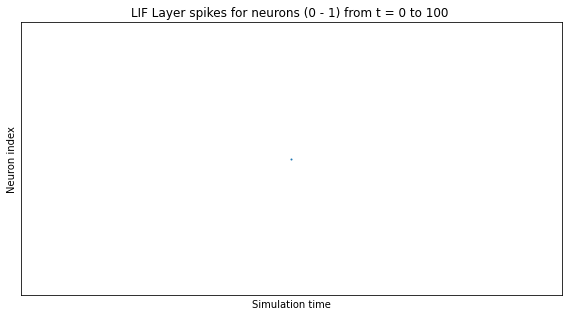

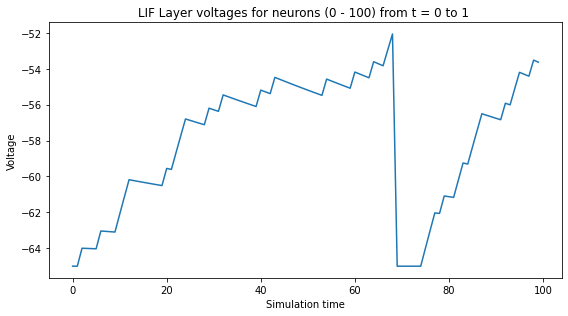

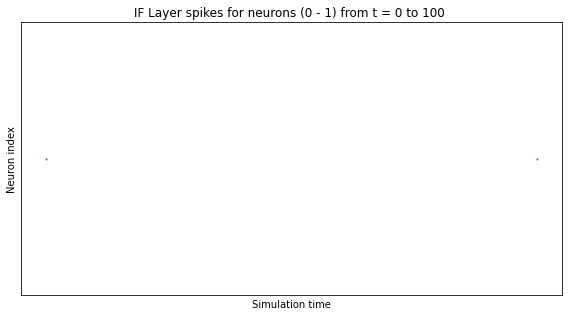

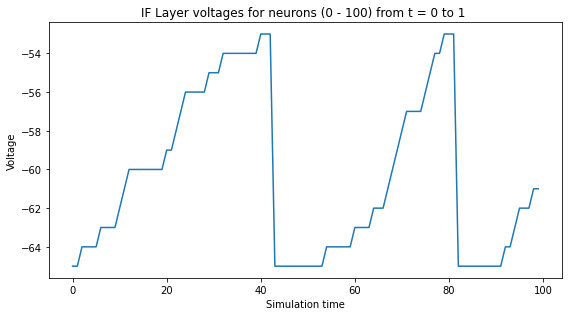

In [138]:
# initialize network
lif_network = Network()
if_network = Network()

# set number of neurons
inputs = 1
neurons = 1

# simulation time
time = 100
dt = 1

# configure weights for the synapses between the input layer and LIF layer
w = torch.round(torch.abs(2 * torch.randn(inputs, neurons)))

# initialize input and LIF layers
lif_input_layer = Input(n=inputs)
if_input_layer = Input(n=inputs)
lif_layer = LIFNodes(n=neurons)
if_layer = IFNodes(n=neurons)

# connection between the input layer and the LIF layer
input_lif_connection = Connection(
    source=lif_input_layer, target=lif_layer,w=w
)
input_if_connection = Connection(
    source=if_input_layer, target=if_layer,w=w
)

# create a monitor
lif_layer_monitor = Monitor(
    obj=lif_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
if_layer_monitor = Monitor(
    obj=if_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

# add layers to network
lif_network.add_layer(
    layer=lif_input_layer, name="LIF Input Layer"
)
lif_network.add_layer(
    layer=lif_layer, name="LIF Layer"
)
if_network.add_layer(
    layer=if_input_layer, name="IF Input Layer"
)
if_network.add_layer(
    layer=if_layer, name="IF Layer"
)


# add connection to network
lif_network.add_connection(
    connection=input_lif_connection, source="LIF Input Layer", target="LIF Layer"
)
if_network.add_connection(
    connection=input_if_connection, source="IF Input Layer", target="IF Layer"
)

# add monitor to the network
lif_network.add_monitor(monitor=lif_layer_monitor, name="LIF Layer")
if_network.add_monitor(monitor=if_layer_monitor, name="IF Layer")

# create input spike data, where each spike is distributed according to Bernoulli(0.1)
input_data = torch.bernoulli(0.3 * torch.ones(time, lif_input_layer.n)).byte()
lif_inputs = {"LIF Input Layer": input_data}
if_inputs = {"IF Input Layer": input_data}

# simulate network on input data
lif_network.run(inputs=lif_inputs, time=time)
if_network.run(inputs=if_inputs, time=time)

# retrieve and plot simulation spike, voltage data from monitors
lif_spikes = {"LIF Layer": lif_layer_monitor.get("s")}
lif_voltages = {"LIF Layer": lif_layer_monitor.get("v")}
if_spikes = {"IF Layer": if_layer_monitor.get("s")}
if_voltages = {"IF Layer": if_layer_monitor.get("v")}

# plot spikes and voltages of the LIF layer
# TODO: plot axes

plot_spikes(lif_spikes)
plot_voltages(lif_voltages, plot_type="line")
plot_spikes(if_spikes)
plot_voltages(if_voltages, plot_type="line")


plt.show()

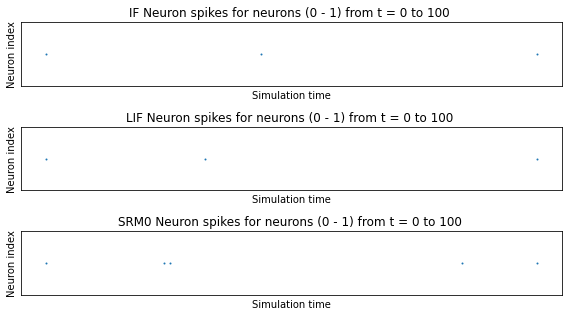

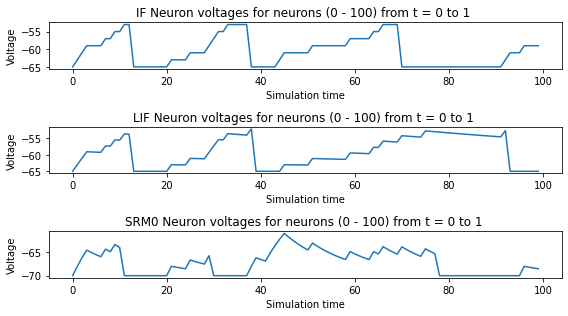

In [139]:
# initialize network
network = Network()
network = Network()

# set number of neurons
num_inputs = 1
num_neurons = 1

# simulation time
time = 100
dt = 1

# configure weights for the synapses between the input layer and LIF layer
w = torch.round(torch.abs(2 * torch.randn(num_inputs, num_neurons)))

# create input spike data, where each spike is distributed according to Bernoulli(0.1)
input_data = torch.bernoulli(0.3 * torch.ones(time, num_inputs)).byte()
inputs = {"Input Layer": input_data}

# initialize list of neuron models
neuron_models = [IFNodes(n=num_neurons),LIFNodes(n=num_neurons),SRM0Nodes(n=num_neurons)]
neuron_types = ["IF Neuron","LIF Neuron","SRM0 Neuron"]
spikes={}
voltages={}

for neuron_model_index in range(len(neuron_models)):
    # initialize input and neuron layers
    input_layer = Input(n=num_inputs)
    neuron_layer = neuron_models[neuron_model_index]

    # connection between the input layer and the LIF layer
    connection = Connection(
        source=input_layer, target=neuron_layer,w=w
    )

    # create a monitor
    neuron_layer_monitor = Monitor(
        obj=neuron_layer,
        state_vars=("s", "v"),  # Record spikes and voltages.
        time=time,  # Length of simulation (if known ahead of time).
    )

    # add layers to network
    network.add_layer(
        layer=input_layer, name="Input Layer"
    )
    network.add_layer(
        layer=neuron_layer, name="Neuron Layer"
    )


    # add connection to network
    network.add_connection(
        connection=connection, source="Input Layer", target="Neuron Layer"
    )

    # add monitor to the network
    network.add_monitor(monitor=neuron_layer_monitor, name="Neuron Layer")

    # simulate network on input data
    network.run(inputs=inputs, time=time)

    # retrieve and plot simulation spike, voltage data from monitors
    #if_spikes = {"Neuron Layer": neuron_layer_monitor.get("s")}
    #if_voltages = {"Neuron Layer": neuron_layer_monitor.get("v")}
    spikes.update({neuron_types[neuron_model_index] : neuron_layer_monitor.get("s")})
    voltages.update({neuron_types[neuron_model_index] : neuron_layer_monitor.get("v")})

# plot spikes and voltages of the LIF layer
# TODO: plot axes
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")

plt.show()

In [140]:
import torch
import matplotlib.pyplot as plt

from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.network.monitors import Monitor

# Build simple network.
network = Network()
network.add_layer(Input(500), name='I')
network.add_monitor(Monitor(network.layers['I'], state_vars=['s']), 'I')

# Generate spikes by running Bernoulli trials on Uniform(0, 0.5) samples.
spikes = torch.bernoulli(0.5 * torch.rand(500, 500))

# Run network simulation.
network.run(inputs={'I' : spikes}, time=500)

# Look at input spiking activity.
spikes = network.monitors['I'].get('s')
plt.matshow(spikes, cmap='binary')
plt.xticks(()); plt.yticks(());
plt.xlabel('Time'); plt.ylabel('Neuron index')
plt.title('Input spiking')
plt.show()

TypeError: Invalid shape (500, 1, 500) for image data